# Predicting Stock Movement with Random Forest

GitHub For this Paper can be found here: https://github.com/LuckysonKhaidem/StockMarketPedicition

Random Forest is a machine learning ensemble method that is widely used because of it's flexibility, simplicity, and often quality results. In this tutorial, we will use the Random Forest algorithim to build a classification model that will help us predict whether a stock will close up or down based on range of technical indicators.

## What is Random Forest?
Now, up above I gave you a pretty simple definition of what Random Forest is. However, I think it's important to delve in more detail about it before we start coding our model. Now in short, Random Forests is a supervised machine learning algorithim that uses multiple decision trees in aggregate to help make more stable and accurate predictions.

After reading that you're probably going, "Well you answered one question but left me with a few more." Let's go over some of those questions.

### What are Decision Trees?
Decision Trees are the fundamental building blocks of Random Forest. In essence, Decision Trees is flowlike chart structure where each node of the tree is used to test a particular attribute of the object. For example, imagine I have a person which will represent our object. We then test certain attributes of this person object. For example, one test would be whether they are male or female. The test will represent a "Decision Node" in our tree, and each of the possible outcomes "Male" or "Female" will represent a leaf node.The first "Decision Node" in our Decision Tree will be our "Root Node"

- **Root Node:** Represents entire population or sample and this further gets divided into two or more homogeneous sets. Our starting point.
- **Splitting:** The process of dividing a node into two or more sub-nodes, for example we split on gender.
- **Decision Node:** When a sub-node splits into further sub-nodes, then it is called decision node.
- **Leaf/Terminal Node:** Nodes do not split is called Leaf or Terminal node.
- **Pruning:** When we remove sub-nodes of a decision node, this process is called pruning. You can say opposite process of splitting.
- **Branch/Sub-Tree:** A sub section of entire tree is called branch or sub-tree.
- **Parent and Child Node:** A node, which is divided into sub-nodes is called parent node of sub-nodes whereas sub-nodes are the child of parent node.

### What is Ensemble Learning?
An Ensemble Learning model is a model in which decisions are used from MULTIPLE MODELS to improve the overall performance of the model. The old idea that 2 minds are better than 1, prefectly summarizes ensemble learning. We use the results of multiple models to get a better idea of what the true answer is. Our Random Forest algorithim uses Bagging to help improve performance.

### Why use Random Forest?
Now, when you read the definition about decision trees you may be thinking, "That sounds like a really simple and intuitive model. Why would we not just use decision trees?". Well, it boils down to the following few points:

1. Instability: Even small changes to the input data can have dramatic changes to the overall strucutre of the decision tree.
2. They are often relatively inaccurate. Many other predictors perform better with similar data.
3. For data including categorical variables with different number of levels, information gain in decision trees is biased in favor of those attributes with more levels.
4. Calculations can get very complex, particularly if many values are uncertain and/or if many outcomes are linked.

These are some of the reasons it's preferable to use Random Forest because we will see that it helps overcome some of the weaknesses of Decision Trees. Now, as with anything, there is no perfect model. Just because something has weaknesses means it's worthless it just means we have to understand those weaknesses and keep eye out for them as we use them.

### What is Supervised Learning?
In machine learning, we have two categories of learning. Supervised learning and unsupervised learning. With unsupervised learning, we don't supervise the model and instead allow it to discover information on it's own. We do this by providing an "UNLABELED" data set that doesn't tell the model what category or value is the "correct" answer.

With supervised learning, we provide the model with a "LABELED" data set which tells the model what the "correct" value it should be. Random Forest, is an example of a supervised learning algorithim because we provide the model a labeled data set.

In [1]:
# Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

## Data Preprocessing: Load the Data
This portion is a little unnecessary because you take the function up above, and it will return the `price_data` data frame and use that. However, if you don't want to go through the process of pulling the data again. What we can do is load the CSV file we used previously. In this portion, I check if the `price_data.csv` file exists in the directory, and if it does, I load it. Otherwise, I call the `get_price_data` and grab the data again.

Finally, I print the `price_data` data frame to verify the data was loaded. `YOU WILL NEED TO RUN THE FUNCTION EVERY DAY TO GET THE LATEST PRICE DATA.`

In [2]:
# Old output

In [3]:
# Load the data
price_data = pd.read_csv('stocks_data/all_stocks_5yr.csv')

# Turn the date column into a datetime object and rename it to datetime
price_data['date'] = pd.to_datetime(price_data['date'])
price_data = price_data.rename(columns={'date': 'datetime'})

# Rename Name column to symbol
price_data = price_data.rename(columns={'Name': 'symbol'})

# Display the head before moving on.
price_data.head()

,datetime,open,high,low,close,volume,symbol
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


With the data now loaded, we can transform so we can calculate some of our trading indicators. The first thing we need to do is sort the data because we have multiple ticker symbols inside of our data frame. Take the data frame and call the `sort_values` method and specify the columns you wish to sort by using the `by` argument. In our case, we will be using a list of column names to sort by. The first sort is by the `symbol` column, and the second sort is by the `datetime` column.

Once we've sorted the data, we need to calculate the change in price from one period to the next. To do this, we will use the `diff()` method. Grab the `close` column and call the `diff()` method. The `diff()` method will calculate the difference from one row to the next.

In [4]:
# I Just need the Close
price_data = price_data[['symbol','datetime','close','high','low','open','volume']]


'''
    First, for average investors, the return of an asset is a complete and scale–free 
    summary of the investment opportunity. Second, return series are easier to 
    handle than prices series as they have more attractive statistical properties
'''

# sort the values by symbol and then date
price_data.sort_values(by = ['symbol','datetime'], inplace = True)

# calculate the change in price
price_data['change_in_price'] = price_data['close'].diff()

### Data Preprocessing: Ticker Symbol
Okay, so we've created our `change_in_price` column, but we need to do an extra step. Technically, each row where the ticker symbol changes are incorrect because it's using the price from a different ticker. That means we need to have the first row of each ticker symbol be `Nan` for the `change_in_price` column. To do this, we need to break out into steps.

Step 1: Identify the rows where the ticker symbol changes. If we use the `shift()` method and shift every row down by one, the rows where unshifted column DOES NOT EQUAL the shifted column is where the ticker changed. We will store these values in a variable called `mask`.

Step 2: Change those rows to `NaN` values. We can use the `numpy.where()` method to test our series. The test is simple, wherever the `mask` variable equals `True`, in other words, wherever the ticker symbol is different, set the `change_in_price` column to `np.nan`.

After doing that, we can filter those `NaN` values; we should only have 5.

In [5]:
# identify rows where the symbol changes
mask = price_data['symbol'] != price_data['symbol'].shift(1)

# For those rows, let's make the value null
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

# print the rows that have a null value, should only be 5
price_data[price_data.isna().any(axis = 1)]

,symbol,datetime,close,high,low,open,volume,change_in_price
71611,A,2013-02-08,45.0800,45.3500,45.0000,45.0700,1824755,NaN
0,AAL,2013-02-08,14.7500,15.1200,14.6300,15.0700,8407500,NaN
2518,AAP,2013-02-08,78.9000,79.7200,78.0100,78.3400,1298137,NaN
1259,AAPL,2013-02-08,67.8542,68.4014,66.8928,67.7142,158168416,NaN
3777,ABBV,2013-02-08,36.2500,36.4200,35.8250,36.3700,13858795,NaN
...,...,...,...,...,...,...,...,...
612745,XYL,2013-02-08,27.0900,27.6400,27.0100,27.0100,1206284,NaN
614004,YUM,2013-02-08,65.3000,65.4900,63.6600,63.7000,7190051,NaN
615263,ZBH,2013-02-08,75.8500,75.9900,74.9600,75.0200,911179,NaN
616522,ZION,2013-02-08,24.1400,24.2100,23.9500,24.0300,2104483,NaN


## Data Preprocessing: Smoothing the Data (OPTIONAL)

***
**This part is optional, in the example below I will not be doing any smoothing of the data this is simply to give you the code necessary to reproduce certain results in the paper.**
***

In the paper, they test the model using different windows. For example, they make predictions 30 days out, 60 days out and 90 days out. To make this type of prediction, we have to transform the data so that when we pass it through the model it will be able to make those predictions that far out. The transformation they use is smoothing factor that is defined by the following:

**Formula**:

\begin{align}
\ S_{0} = Y_{0}
\\
\end{align}

\begin{align}
\ \text{for }t > 0\text{, } S_{t} = \alpha * Y_{t} + ( 1 - \alpha ) * S_{t-1}
\
\end{align}

where α is the smoothing factor and 0 < α < 1. Larger values of α reduce the level of smoothing. When α = 1, the smoothed statistic becomes equal to the actual observation. The goal of smoothing it remove the randomess and noise from our price data. In other words, we don't get a spiky up and down graph but instea a smoother one. Additionally,this will help the model to more easily identify long-term trends.

Here is how to calculate the smoothed version of the prices using `pandas`:

In [6]:
# define the number of days out you want to predict
days_out = 30

# Group by symbol, then apply the rolling function and grab the Min and Max.
price_data_smoothed = price_data.groupby(['symbol'])[['close','low','high','open','volume']].transform(lambda x: x.ewm(span = days_out).mean())

# Join the smoothed columns with the symbol and datetime column from the old data frame.
smoothed_df = pd.concat([price_data[['symbol','datetime']], price_data_smoothed], axis=1, sort=False)

smoothed_df

,symbol,datetime,close,low,high,open,volume
71611,A,2013-02-08,45.080000,45.000000,45.350000,45.070000,1.824755e+06
71612,A,2013-02-11,44.832000,44.715833,45.262167,45.121667,2.388258e+06
71613,A,2013-02-12,44.756572,44.639041,45.151100,45.010777,2.383089e+06
71614,A,2013-02-13,44.754761,44.650327,45.175595,44.955456,2.291955e+06
71615,A,2013-02-14,44.714999,44.584270,45.085587,44.901884,2.641043e+06
...,...,...,...,...,...,...,...
619035,ZTS,2018-02-01,75.587702,75.011922,76.083250,75.530018,2.672917e+06
619036,ZTS,2018-02-02,75.664624,75.122766,76.214653,75.659049,2.667903e+06
619037,ZTS,2018-02-05,75.546262,74.997426,76.260159,75.722337,2.686879e+06
619038,ZTS,2018-02-06,75.399406,74.812431,76.150472,75.529928,2.831230e+06


## Data Preprocessing: Signal Flag

If you chose to do the smoothing process then we need to add an additional column to our data frame. This will serve as `diff` column from the original data frame. However, in this case, we don't want one consecutive day to the next we want the number of days we want to predict out. What we will do is take the window we used up above to calculate our smoothed statistic and use it to calculate our signal flag.

We will be using the `numpy.sign()` method which will return a `1.0` if positive, `-1.0` if negative and `0.0` if no change.

In [7]:
# define the number of days out you want to predict
days_out = 30

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
smoothed_df['Signal_Flag'] = smoothed_df.groupby('symbol')['close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
smoothed_df.head(50)

,symbol,datetime,close,low,high,open,volume,Signal_Flag
71611,A,2013-02-08,45.080000,45.000000,45.350000,45.070000,1.824755e+06,NaN
71612,A,2013-02-11,44.832000,44.715833,45.262167,45.121667,2.388258e+06,NaN
71613,A,2013-02-12,44.756572,44.639041,45.151100,45.010777,2.383089e+06,NaN
71614,A,2013-02-13,44.754761,44.650327,45.175595,44.955456,2.291955e+06,NaN
71615,A,2013-02-14,44.714999,44.584270,45.085587,44.901884,2.641043e+06,NaN
71616,A,2013-02-15,44.232760,44.119782,44.920162,44.623715,4.991837e+06,NaN
71617,A,2013-02-19,44.021276,43.789473,44.608812,44.206247,4.840380e+06,NaN
71618,A,2013-02-20,43.743333,43.545359,44.334374,43.993063,4.689463e+06,NaN
71619,A,2013-02-21,43.441226,43.248680,44.020682,43.728163,4.507296e+06,NaN
71620,A,2013-02-22,43.223672,43.027487,43.762108,43.476550,4.354534e+06,NaN


## Indicator Calculation: Relative Strength Index (RSI)

**Definition From Paper:**

RSI is a popular momentum indicator that determines whether the stock is overbought or oversold. A stock is said to be overbought when the demand unjustifiably pushes
the price upwards. This condition is generally interpreted as a sign that the stock is overvalued, and the price is likely to go down. A stock is said to be oversold when the price goes down sharply to a level below its true value. This is a result caused due to panic selling. RSI ranges from 0 to 100, and generally, when RSI is above 70, it may indicate that the stock is overbought and when RSI is below 30, it may indicate the stock is oversold.

**Formula**:

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

**Code:**

From this point forward, a lot of the calculations will be mostly the same but only differ on the type of calculation we do. Each indicator is calculated using the same few steps:

1. Copy the desired columns and store them in new variables.
2. Group the columns by the `symbol`, select the column we wish to perform the transformation on and use the `transform` method along with a lambda function to calculate the indicator.
3. Store the values in the main data frame.

Now there might be a few extra steps in between, but the general idea is the same across each indicator. Now for the RSI indicator, I need to identify the up days and down days. Well, lucky for us, we already have the `change_in_price ` column, so we can use a condition that will set the value to 0 if the price went up for down days and vice versa for up days. After that, I need to make sure I have the absolute values for down days, or else the calculation won't be correct, so I modify that column and then calculate the EMA of both the Up and Down columns. Finally, I calculate the Relative strength metric and pass that through to the RSI calculation.

In [8]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI
71611,A,2013-02-08,45.08,45.350,45.000,45.07,1824755,NaN,NaN,NaN,NaN
71612,A,2013-02-11,44.60,45.180,44.450,45.17,2915405,-0.48,0.48,0.00,0.000000
71613,A,2013-02-12,44.62,44.950,44.500,44.81,2373731,0.02,0.00,0.02,4.587156
71614,A,2013-02-13,44.75,45.240,44.680,44.81,2052338,0.13,0.00,0.13,29.010239
71615,A,2013-02-14,44.58,44.780,44.360,44.72,3826245,-0.17,0.17,0.00,20.927421
71616,A,2013-02-15,42.25,44.240,42.210,43.48,14657315,-2.33,2.33,0.00,3.870988
71617,A,2013-02-19,43.01,43.120,42.210,42.21,4116141,0.76,0.00,0.76,26.436312
71618,A,2013-02-20,42.24,42.850,42.225,42.84,3873183,-0.77,0.77,0.00,20.743836
71619,A,2013-02-21,41.63,42.140,41.470,42.14,3415149,-0.61,0.61,0.00,17.332342
71620,A,2013-02-22,41.80,42.070,41.580,41.83,3354862,0.17,0.00,0.17,21.484537


## Indicator Calculation: Stochastic Oscillator

**Definition From Paper:**

Stochastic Oscillator follows the speed or the momentum of the price. As a rule, momentum changes before the price changes. It measures the level of the closing price relative to the low-high range over a period of time.

**Formula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$

**Code:**

The strategy here is pretty much the same; the only difference is the columns we are copying and the lambda function we are applying. For the RSI, we applied an EMA function, but for the Stochastic Oscillator, we use the rolling function. With this function, we specify our window, which in this case is 14 periods, and then specify measurement we want to apply to each window.

After we obtained the max and min values, we pass it through our formula and apply the results to the main data frame.

In [9]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
71611,A,2013-02-08,45.08,45.350,45.000,45.07,1824755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71612,A,2013-02-11,44.60,45.180,44.450,45.17,2915405,-0.48,0.48,0.00,0.000000,NaN,NaN,NaN
71613,A,2013-02-12,44.62,44.950,44.500,44.81,2373731,0.02,0.00,0.02,4.587156,NaN,NaN,NaN
71614,A,2013-02-13,44.75,45.240,44.680,44.81,2052338,0.13,0.00,0.13,29.010239,NaN,NaN,NaN
71615,A,2013-02-14,44.58,44.780,44.360,44.72,3826245,-0.17,0.17,0.00,20.927421,NaN,NaN,NaN
71616,A,2013-02-15,42.25,44.240,42.210,43.48,14657315,-2.33,2.33,0.00,3.870988,NaN,NaN,NaN
71617,A,2013-02-19,43.01,43.120,42.210,42.21,4116141,0.76,0.00,0.76,26.436312,NaN,NaN,NaN
71618,A,2013-02-20,42.24,42.850,42.225,42.84,3873183,-0.77,0.77,0.00,20.743836,NaN,NaN,NaN
71619,A,2013-02-21,41.63,42.140,41.470,42.14,3415149,-0.61,0.61,0.00,17.332342,NaN,NaN,NaN
71620,A,2013-02-22,41.80,42.070,41.580,41.83,3354862,0.17,0.00,0.17,21.484537,NaN,NaN,NaN


## Indicator Calculation: Williams %R

**Definition From Paper:**

Williams %R ranges from -100 to 0. When its value is above -20, it indicates a sell signal and when its value is below -80, it indicates a buy signal.


**Formula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$

**Code:**

Identical to the Stochastic Oscillator, we change the arrangement of the formula.

In [10]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
71611,A,2013-02-08,45.08,45.350,45.000,45.07,1824755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71612,A,2013-02-11,44.60,45.180,44.450,45.17,2915405,-0.48,0.48,0.00,0.000000,NaN,NaN,NaN,NaN
71613,A,2013-02-12,44.62,44.950,44.500,44.81,2373731,0.02,0.00,0.02,4.587156,NaN,NaN,NaN,NaN
71614,A,2013-02-13,44.75,45.240,44.680,44.81,2052338,0.13,0.00,0.13,29.010239,NaN,NaN,NaN,NaN
71615,A,2013-02-14,44.58,44.780,44.360,44.72,3826245,-0.17,0.17,0.00,20.927421,NaN,NaN,NaN,NaN
71616,A,2013-02-15,42.25,44.240,42.210,43.48,14657315,-2.33,2.33,0.00,3.870988,NaN,NaN,NaN,NaN
71617,A,2013-02-19,43.01,43.120,42.210,42.21,4116141,0.76,0.00,0.76,26.436312,NaN,NaN,NaN,NaN
71618,A,2013-02-20,42.24,42.850,42.225,42.84,3873183,-0.77,0.77,0.00,20.743836,NaN,NaN,NaN,NaN
71619,A,2013-02-21,41.63,42.140,41.470,42.14,3415149,-0.61,0.61,0.00,17.332342,NaN,NaN,NaN,NaN
71620,A,2013-02-22,41.80,42.070,41.580,41.83,3354862,0.17,0.00,0.17,21.484537,NaN,NaN,NaN,NaN


## Indicator Calculation: Moving Average Convergence Divergnece (MACD)

**Definition From Paper:**

EMA stands for Exponential Moving Average. When the MACD goes below the SingalLine, it indicates a sell signal. When it goes above the SignalLine, it indicates a buy signal.


**Formula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$

**Code:**

For the MACD, we will need the `close` column, so grab that and then apply the `transform` method along with the specified Lambda function. Now calculating an Exponential Moving Average in `pandas` is easy. First, call the `ewm` (exponential moving weight) function and then specify the `span` or, in other words, the number of periods to look back. In this case, we use the definition provided by the formula and specify 26 & 12.

Once we've calculated the EMA_26 and EMA_12, we take the difference between EMA_12 & EMA_26 to get our MACD. Now that we have our MACD, we need to calculate the EMA of the MACD, so we take our MACD series and apply the same `ewm` function too, but in this case, we specify a `span` of 9. Finally, we add both the MACD and MACD_EMA to the main data frame.

In [11]:
# Calculate the MACD
ema_26 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# Print the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
71611,A,2013-02-08,45.08,45.350,45.000,45.07,1824755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
71612,A,2013-02-11,44.60,45.180,44.450,45.17,2915405,-0.48,0.48,0.00,0.000000,NaN,NaN,NaN,NaN,-0.010769,-0.005983
71613,A,2013-02-12,44.62,44.950,44.500,44.81,2373731,0.02,0.00,0.02,4.587156,NaN,NaN,NaN,NaN,-0.013102,-0.008901
71614,A,2013-02-13,44.75,45.240,44.680,44.81,2052338,0.13,0.00,0.13,29.010239,NaN,NaN,NaN,NaN,-0.009148,-0.008984
71615,A,2013-02-14,44.58,44.780,44.360,44.72,3826245,-0.17,0.17,0.00,20.927421,NaN,NaN,NaN,NaN,-0.013572,-0.010349
71616,A,2013-02-15,42.25,44.240,42.210,43.48,14657315,-2.33,2.33,0.00,3.870988,NaN,NaN,NaN,NaN,-0.115608,-0.038880
71617,A,2013-02-19,43.01,43.120,42.210,42.21,4116141,0.76,0.00,0.76,26.436312,NaN,NaN,NaN,NaN,-0.144624,-0.065641
71618,A,2013-02-20,42.24,42.850,42.225,42.84,3873183,-0.77,0.77,0.00,20.743836,NaN,NaN,NaN,NaN,-0.198376,-0.097540
71619,A,2013-02-21,41.63,42.140,41.470,42.14,3415149,-0.61,0.61,0.00,17.332342,NaN,NaN,NaN,NaN,-0.262845,-0.135726
71620,A,2013-02-22,41.80,42.070,41.580,41.83,3354862,0.17,0.00,0.17,21.484537,NaN,NaN,NaN,NaN,-0.295996,-0.171636


### Indicator Calculation: Price Rate Of Change

**Definition From Paper:**

It measures the most recent change in price with respect to the price in `n` days ago.

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


**Code:**

The Price Rate of Change is another easy indicator to calculate in pandas because we can leverage a built-in function. In this case, we will use the `pct_change` function and apply it to our all too familiar symbol groups. For the `pct_change` function, we have an argument called `periods` which specifies how far we need to look back when calculating the rate of change. In this case, the paper never provided a specific `n,` but after doing some research, I landed on an `n` of 9 because this seemed to be the standard window. Now, it's important to note that the paper changes `n` depending on the window, so technically I'm not doing exactly like they did. For example, if my prediction window was `30 days` then `n` should be 30.

In [12]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_data['Price_Rate_Of_Change'] = price_data.groupby('symbol')['close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
71611,A,2013-02-08,45.08,45.350,45.000,45.07,1824755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
71612,A,2013-02-11,44.60,45.180,44.450,45.17,2915405,-0.48,0.48,0.00,0.000000,NaN,NaN,NaN,NaN,-0.010769,-0.005983,NaN
71613,A,2013-02-12,44.62,44.950,44.500,44.81,2373731,0.02,0.00,0.02,4.587156,NaN,NaN,NaN,NaN,-0.013102,-0.008901,NaN
71614,A,2013-02-13,44.75,45.240,44.680,44.81,2052338,0.13,0.00,0.13,29.010239,NaN,NaN,NaN,NaN,-0.009148,-0.008984,NaN
71615,A,2013-02-14,44.58,44.780,44.360,44.72,3826245,-0.17,0.17,0.00,20.927421,NaN,NaN,NaN,NaN,-0.013572,-0.010349,NaN
71616,A,2013-02-15,42.25,44.240,42.210,43.48,14657315,-2.33,2.33,0.00,3.870988,NaN,NaN,NaN,NaN,-0.115608,-0.038880,NaN
71617,A,2013-02-19,43.01,43.120,42.210,42.21,4116141,0.76,0.00,0.76,26.436312,NaN,NaN,NaN,NaN,-0.144624,-0.065641,NaN
71618,A,2013-02-20,42.24,42.850,42.225,42.84,3873183,-0.77,0.77,0.00,20.743836,NaN,NaN,NaN,NaN,-0.198376,-0.097540,NaN
71619,A,2013-02-21,41.63,42.140,41.470,42.14,3415149,-0.61,0.61,0.00,17.332342,NaN,NaN,NaN,NaN,-0.262845,-0.135726,NaN
71620,A,2013-02-22,41.80,42.070,41.580,41.83,3354862,0.17,0.00,0.17,21.484537,NaN,NaN,NaN,NaN,-0.295996,-0.171636,-0.072760


## Indicator Calculation: On Balance Volume

#### Definition From Paper:

On balance volume (OBV) (Granville 1976) utilizes changes in volume to estimate changes in stock prices. This technical indicator is used to d buying and selling trends of a stock, by considering the cumulative volume: it cumulatively adds the volumes on days when the prices group, and subtracts the volume on the days when prices go down, compared to the prices of the previous day.

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$

**Code:**

This portion is a little more complicated than the previous ones. However, the idea is still the same. I'm going to be working with groups but in this case I'll be using the `apply` method to apply a custom function I built to calculate the `On Balance Volume`. The function simply calculates the `diff` for the closing price and uses a `for loop` to loop through each row in the `volume` column. If the `change in price`  was greater than 0 we add the volume, if it's less than 0 we subtract the volume and if it's 0 then we leave it alone.

When I return the values I need to make sure it's a `pandas.Series` object with an `index`. Once I have the `pandas.Series` I just add it to the dataframe like in previous examples.

In [13]:
def obv(group):

    # Grab the volume and close column.
    volume = group['volume']
    change = group['close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = price_data.groupby('symbol').apply(obv)

# add to the data frame, but drop the old index, before adding it.
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
71611,A,2013-02-08,45.08,45.350,45.000,45.07,1824755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
71612,A,2013-02-11,44.60,45.180,44.450,45.17,2915405,-0.48,0.48,0.00,0.000000,NaN,NaN,NaN,NaN,-0.010769,-0.005983,NaN,-2915405
71613,A,2013-02-12,44.62,44.950,44.500,44.81,2373731,0.02,0.00,0.02,4.587156,NaN,NaN,NaN,NaN,-0.013102,-0.008901,NaN,-541674
71614,A,2013-02-13,44.75,45.240,44.680,44.81,2052338,0.13,0.00,0.13,29.010239,NaN,NaN,NaN,NaN,-0.009148,-0.008984,NaN,1510664
71615,A,2013-02-14,44.58,44.780,44.360,44.72,3826245,-0.17,0.17,0.00,20.927421,NaN,NaN,NaN,NaN,-0.013572,-0.010349,NaN,-2315581
71616,A,2013-02-15,42.25,44.240,42.210,43.48,14657315,-2.33,2.33,0.00,3.870988,NaN,NaN,NaN,NaN,-0.115608,-0.038880,NaN,-16972896
71617,A,2013-02-19,43.01,43.120,42.210,42.21,4116141,0.76,0.00,0.76,26.436312,NaN,NaN,NaN,NaN,-0.144624,-0.065641,NaN,-12856755
71618,A,2013-02-20,42.24,42.850,42.225,42.84,3873183,-0.77,0.77,0.00,20.743836,NaN,NaN,NaN,NaN,-0.198376,-0.097540,NaN,-16729938
71619,A,2013-02-21,41.63,42.140,41.470,42.14,3415149,-0.61,0.61,0.00,17.332342,NaN,NaN,NaN,NaN,-0.262845,-0.135726,NaN,-20145087
71620,A,2013-02-22,41.80,42.070,41.580,41.83,3354862,0.17,0.00,0.17,21.484537,NaN,NaN,NaN,NaN,-0.295996,-0.171636,-0.072760,-16790225


## Building the Model: Creating the Prediction Column
Now that we have our technical indicators calculated and our price data cleaned up, we are almost ready to build our model. However, we are missing one critical piece of information that is crucial to the model, the column we wish to predict. Now at this point, our data frame doesn't have that column, but we will create it before we feed the data into the model.

However, before we create it, I want to take some time and understand the exact problem we are trying to solve. Our goal is to predict whether the next day is either a `down_day` or an `up_day`. Based on this knowledge, we are solving a classification problem. If you don't remember, there are two categories of problems in machine learning, classification, and regression. With classification problems, we try to predict which group new values belong to. For example, based on store sales, are they `outperforming store` or an `underperforming store`. Classification problems are problems that have discrete groups. With regression problems, we are trying to predict non-discrete values and, for example, trying to forecast future sales based on previous sales.

In our case, we have a classification problem because we have two discrete groups, `up_days` and `down_days`, and our goal is to take new values (new prices) and classify them into these two groups based on their values.

To create our prediction column, we will group our data frame by each `symbol`. After we've created our groups, we need to select the `close` column as this contains the price we need to determine if the stock closed up or down for any given day. Now, we can use a similar logic we used to calculate the price change. However, in this case, we only need to know if the price is higher or lower compared to the previous day.

Take your groups, use the `transform` method to apply a lambda function to your groups. The lambda function will use the `diff()` function to compare the current price to the previouse price. We then wrap the results of that function in the `numpy.sign()` function. That function will return `1.0` for negative values (down days), `1.0` for postive values, and `0.0` for no change (flat days).

In [14]:
# Create a column we wish to predict
'''
    In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data.groupby('symbol')['close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

# print the head
price_data.head(50)

# OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
# price_data.to_csv('final_metrics.csv')

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
71611,A,2013-02-08 00:00:00,45.08,45.3500,45.0000,45.07,1824755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0,NaN
71612,A,2013-02-11 00:00:00,44.60,45.1800,44.4500,45.17,2915405,-0.48,0.48,0.00,0.000000,NaN,NaN,NaN,NaN,-0.010769,-0.005983,NaN,-2915405,-1.0
71613,A,2013-02-12 00:00:00,44.62,44.9500,44.5000,44.81,2373731,0.02,0.00,0.02,4.587156,NaN,NaN,NaN,NaN,-0.013102,-0.008901,NaN,-541674,1.0
71614,A,2013-02-13 00:00:00,44.75,45.2400,44.6800,44.81,2052338,0.13,0.00,0.13,29.010239,NaN,NaN,NaN,NaN,-0.009148,-0.008984,NaN,1510664,1.0
71615,A,2013-02-14 00:00:00,44.58,44.7800,44.3600,44.72,3826245,-0.17,0.17,0.00,20.927421,NaN,NaN,NaN,NaN,-0.013572,-0.010349,NaN,-2315581,-1.0
71616,A,2013-02-15 00:00:00,42.25,44.2400,42.2100,43.48,14657315,-2.33,2.33,0.00,3.870988,NaN,NaN,NaN,NaN,-0.115608,-0.038880,NaN,-16972896,-1.0
71617,A,2013-02-19 00:00:00,43.01,43.1200,42.2100,42.21,4116141,0.76,0.00,0.76,26.436312,NaN,NaN,NaN,NaN,-0.144624,-0.065641,NaN,-12856755,1.0
71618,A,2013-02-20 00:00:00,42.24,42.8500,42.2250,42.84,3873183,-0.77,0.77,0.00,20.743836,NaN,NaN,NaN,NaN,-0.198376,-0.097540,NaN,-16729938,-1.0
71619,A,2013-02-21 00:00:00,41.63,42.1400,41.4700,42.14,3415149,-0.61,0.61,0.00,17.332342,NaN,NaN,NaN,NaN,-0.262845,-0.135726,NaN,-20145087,-1.0
71620,A,2013-02-22 00:00:00,41.80,42.0700,41.5800,41.83,3354862,0.17,0.00,0.17,21.484537,NaN,NaN,NaN,NaN,-0.295996,-0.171636,-0.072760,-16790225,1.0


## Building the Model: Removing `NaN` Values

The random forest can't accept `Nan` values, so we will need to remove them before feeding the data in. The code below prints the number of rows before dropping the `NaN` values, use the `dropna` method to remove any rows `NaN` values and then displays the number of rows after dropping the `NaN` values.

In [15]:
import re
# Look at all the different types of values in the 'datetime' column. 
unique_values = price_data['datetime'].astype(str).unique()
# See if there are any values that are not in the format we expect.
print([x for x in unique_values if not re.match(r'\d{4}-\d{2}-\d{2}', x)])
# Drop those values that are not in the format we expect.
price_data = price_data[price_data['datetime'].astype(str).str.match(r'\d{4}-\d{2}-\d{2}')]
# Convert the column to a datetime object.
price_data['datetime'] = pd.to_datetime(price_data['datetime'])

# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

['1.0']
Before NaN Drop we have 613944 rows and 20 columns
After NaN Drop we have 607372 rows and 20 columns


,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
71624,A,2013-02-28,41.48,42.06,41.45,41.78,3464202,-0.25,0.25,0.00,31.526668,40.19,45.35,25.000000,-75.000000,-0.377195,-0.296696,-0.069538,-26498313,-1.0
71625,A,2013-03-01,41.93,41.98,40.73,41.18,3089323,0.45,0.00,0.45,40.620265,40.19,45.24,34.455446,-65.544554,-0.345576,-0.306828,-0.007574,-23408990,1.0
71626,A,2013-03-04,42.03,42.18,41.52,41.75,2435306,0.10,0.00,0.10,42.575709,40.19,45.24,36.435644,-63.564356,-0.311175,-0.307723,-0.022785,-20973684,1.0
71627,A,2013-03-05,42.66,43.19,42.34,42.35,3289188,0.63,0.00,0.63,53.667079,40.19,45.24,48.910891,-51.089109,-0.242091,-0.294294,0.009943,-17684496,1.0
71628,A,2013-03-06,43.24,43.52,42.90,43.00,2996908,0.58,0.00,0.58,61.555033,40.19,44.78,66.448802,-33.551198,-0.149643,-0.264833,0.038674,-14687588,1.0


## Building the Model: Splitting the Data
If you remember back to our series on regression analysis, we have split our data into a training set and testing set. For Random Forest, we need to do the same, so we need to identify our input columns which are the following:

1. RSI
2. Stochastic Oscillator
3. William %R
4. Price Rate of Change
5. MACD

Those columns will serve as our `X`, and our `Y` column will be the `Prediction` column, the column that specifies whether the stock closed up or down compared to the previous day.

Once we've selected our columns, we need to split the data into a training and test set. SciKit learn makes this easy by providing the `train_test_split` object, which will take our `X_Cols` and `Y_Cols` and split them based on the size we input. In our case, let's have the `test_size` be '20 %`. For reproducibility, the `train_test_split` object provides the `random_state` argument that will split the data along the same dimensions every time.

After we've split the data, we can create our `RandomForestClassifier` model.

Once we've created it, we can `fit` the training data to the model using the `fit` method. Finally, with our "trained" model, we can make predictions. Take the `X_test` data set and use it to make predictions.

In [16]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Convert 'datetime' column to datetime data type
price_data['datetime'] = pd.to_datetime(price_data['datetime'])

# Sort the price_data DataFrame by the datetime column
price_data_sorted = price_data.sort_values('datetime')

# Calculate the index to split the data based on the desired ratio
split_index = int(len(price_data_sorted) * 0.8)

# Split data into train and test sets based on the calculated index
train_data = price_data_sorted[:split_index]
test_data = price_data_sorted[split_index:]

# Save train and test sets to separate files
train_data.to_csv('stocks_data/train_all_stocks_5yr.csv', index=False)
test_data.to_csv('stocks_data/test_all_stocks_5yr.csv', index=False)

# Grab the X and Y columns from the train and test sets
X_train = train_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'On Balance Volume']]
y_train = train_data['Prediction']
X_test = test_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'On Balance Volume']]
y_test = test_data['Prediction']

In [88]:
import joblib

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(rand_frst_clf, 'models/RF_stock_predictor.joblib')

['models/RF_stock_predictor.joblib']

In [89]:
import joblib

# Load the trained model from the file
trained_model = joblib.load('models/RF_stock_predictor.joblib')

# Make predictions using the loaded model
y_pred = trained_model.predict(X_test)

## Model Evaluation: Accuracy
We've built our model, so let's see how accurate it is. SciKit learn, again, makes the process of evaluating our model very easy by providing a bunch of built-in metrics that we can call.

One of those metrics is the `accuracy_score`.

The accuracy_score function computes the accuracy, either the fraction (default) or the count (`normalize`=`False`) of correct predictions. Accuracy is defined as the number of accurate predictions the model made on the test set. Imagine we had three **`TRUE`** values `[1, 2, 3]`, and our model predicted the following values `[1, 2, 4]` we would say the accuracy of our model is `66 %`.

Now I can almost guarantee that your accuracy will be different than mine because if you don't run this model using the same data set as I did, then it could be higher or lower. In my case, the model accuracy was around `71.1%`, which is pretty high.

In [90]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  70.9997941963367


## Model Evaluation: Classification Report
To get a more detailed overview of how the model performed, we can build a classification report that will compute the `F1_Score`, the `Precision`, the `Recall`, and the `Support`. Now, I'm assuming you don't know what these metrics are, so let's take some time to go over them.

### Accuracy:
Accuracy measures the portion of all testing samples classified correctly and is defined as the following:

\begin{align}
\\
\ Accuracy = \frac{tp + tn}{(tp +tn)+(fp-fn)}
\\
\end{align}

$
\begin{align}
\ where,
\\
\ tp = \text{True Positive}
\\
\ tn = \text{True Negative}
\\
\ fp = \text{False Positive}
\\
\ fn = \text{False Negative}
\\
\end{align}
$

### Recall
Recall (also known as sensitivity) measures the ability of a classifier to correctly identify positive labels and is defined as the following:

$$
\begin{align}
\\
\ Recall = \frac{tp}{(tp +fn)}
\\
\end{align}
$$

$
\begin{align}
\ where,
\\
\ tp = \text{True Positive}
\\
\ fn = \text{False Negative}
\\
\end{align}
$

The recall is intuitively the ability of the classifier to find all the positive samples. The best value is 1, and the worst value is 0.

### Specificity
Specificity measures the classifier’s ability to correctly identify negative labels and is defined as the following:

$$
\begin{align}
\\
\ Specificity = \frac{tn}{(tn +fp)}
\\
\end{align}
$$

$
\begin{align}
\ where,
\\
\ tn = \text{True Negative}
\\
\ fp = \text{False Positive}
\\
\end{align}
$

### Percision
Precision measures the proportion of all correctly identified samples in a population of samples which are classified as positive labels and is defined as the following:

$$
\begin{align}
\\
\ Percision = \frac{tp}{(tp +fp)}
\\
\end{align}
$$

$
\begin{align}
\ where,
\\
\ tp = \text{True Positive}
\\
\ fp = \text{False Positive}
\\
\end{align}
$

The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1, and the worst value is 0.


### Interpreting the Classification Report
Now the fun part, interpretation. When it comes to evaluating the model, there we generally look at the accuracy. If our accuracy is high, it means our model is correctly classifying items.

In some cases, we will have models that may have low precision or high recall. It's difficult to compare two models with low precision and high recall or vice versa. To make results comparable, we use a metric called the F-Score. The F-score helps to measure Recall and Precision at the same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.

In [32]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.697975,0.696341,0.697157,57660.000000
Up Day,0.730502,0.732023,0.731262,64834.000000
accuracy,0.715227,0.715227,0.715227,0.715227
macro avg,0.714239,0.714182,0.714209,122494.000000
weighted avg,0.715191,0.715227,0.715208,122494.000000


## Model Evaluation: Confusion Matrix

Accuracy: 0.7152268682547717
Percision: 0.7305022395296218
Recall: 0.7320233210969553
Specificity: 0.6963406174124176


/Users/danielgeorge/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


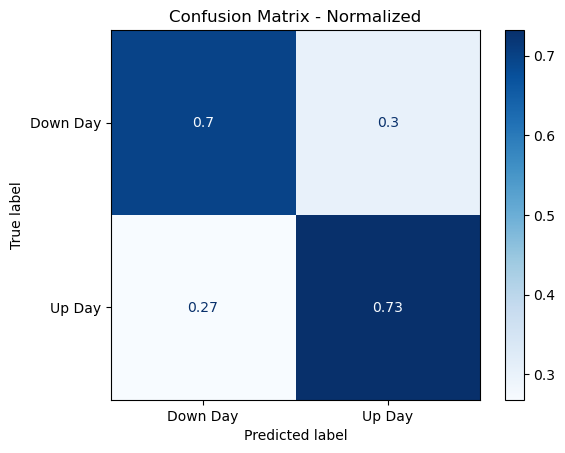

In [33]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

## Model Evaluation: Feature Importance
With any model, you want to have an idea of what features are helping explain most of the model, as this can give you insight as to why you're getting the results you are. With Random Forest, we can identify some of our most important features or, in other words, the features that help explain most of the model. In some cases, some of our features might not be very important, or in other words, when compared to additional features, don't explain much of the model.

### Why Do We Care About Feature Importance?
What that means is if we were to get rid of those features, our accuracy will go down a little, hopefully, but not significantly. You might be asking, "Why would I want to get rid of a feature if it lowers my accuracy?" Well, it depends, in some cases, you don't care if your model is 95% accurate or 92% accurate. To you, a 92% accurate model is just as good as a 95% accurate model.

However, if you wanted to get a 95% accurate model, you would, in this hypothetical case, have to train your model twice as long. Now, I'm a little extreme in this case, but the idea is the same. The cost doesn't justify the benefit. In the real world, we have to make these decisions all the time, and in some cases, it just doesn't warrant the extra cost for such a minimal increase in the accuracy.

### Calculating the Feature Importance
Like all the previous steps, SkLearn makes this process very easy. Take your `rand_frst_clf` and call the `feature_importances_` property. This will return all of our features and their importance measurement. Store the values in a `Pandas.Series` object and sore the values.

Feature importance can be calculated two ways in Random Forest:

1. Gini-Based Importance
2. Accuracy-Based Importance

Here is how both measures of importance are calculated.

With `sklearn` they use the Gini-Importance metric for the Random Forest Algorithm.

We can see in our model, that the most important feature is `k_percent` and our least important feature is `Price_Rate_Of_Change`.

In [34]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

r_percent               0.191454
k_percent               0.189292
RSI                     0.186913
MACD                    0.157442
Price_Rate_Of_Change    0.152984
On Balance Volume       0.121915
dtype: float64

## Model Evaluation: Feature Importance Graphing
If you want, you can also graph the feature importance of our model, so it's a little easier to visualize the results. What I do in the chart below is chart the cumulative importance or, in other words, how much does each feature add to the total. That way, we can see how much each feature is contributing to the overall importance. Another standard graph that is used is a bar chart.

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

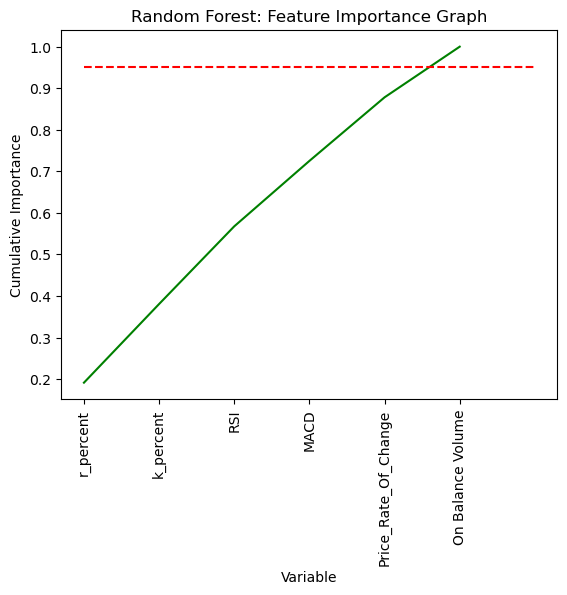

In [35]:
# store the values in a list to plot.
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

## Model Evaluation: ROC Curve
The Receiver Operating Characteristic is a graphical method to evaluate the performance of a binary classifier. A curve is drawn by plotting True Positive Rate (sensitivity) against False Positive Rate (1 - specificity) at various threshold values. ROC curve shows the trade-off between sensitivity and specificity. When the curve comes closer to the left-hand border and the top border of the ROC space, it indicates that the test is accurate. The closer the curve is to the top and left-hand border, the more accurate the test is. If the curve is close to the 45 degrees diagonal of the ROC space, it means that the test is not accurate. ROC curves can be used to select the optimal model and discard the suboptimal ones.

/Users/danielgeorge/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


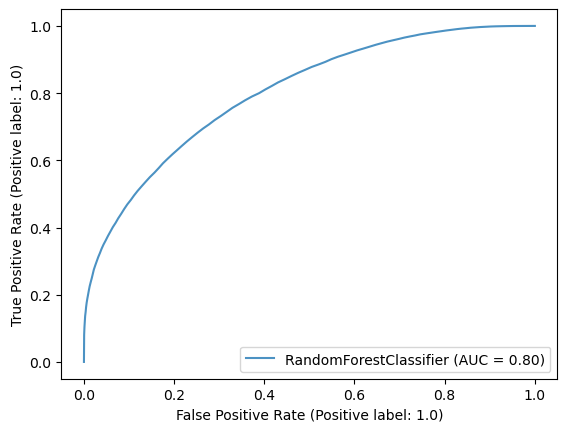

In [36]:
# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()

## Model Evaluation: Out-Of-Bag Error Score
The oob_score uses a sample of "left-over" data that wasn't necessarily used during the model's analysis, and the validation set is a sample of data you decided to subset. In this way, the OOB sample is a little more random than the validation set. Therefore, the OOB sample (on which the oob_score is measured) may be "harder" that the validation set. The oob_score may, on average, have a "less good" accuracy score as a consequence.

For example, Jeremy and Terence use only the last 2 weeks of grocery store data as a validation set. The OOB sample may have unused data from across all four years of sales data. The oob_score's sample is much harder because it's more randomized and has more variance.

If the oob_score never improves, but the validation set score is always excellent. You need to re-think how to subset the validation set. In the case of Jeremy and Terence, they might decide to take a more random sample of data across all years rather than strictly the last 2 weeks of data.

In [37]:
print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_frst_clf.oob_score_))

Random Forest Out-Of-Bag Error Score: 0.7101825811165491


## Model Improvement: Randomized Search
If you remember way up above, I mentioned that there is no magic number of estimators to use with every data set. Instead, with Random Forest, we have to try different values to find what the optimal values should be for each of the parameters. Fortunately, for us, this can be done using the `RandomizedSearchCV` method provided by `sklearn`.

The idea behind this approach is to provide a wide range of possible values for each hyperparameter and then using cross-validation, to try different combinations of these parameters. With the highest result of these combinations being the one, we should use for our data set.

To use this method, we need to first import the `RandomizedSearchCV` object from the `sklearn.model_selection` module. From there, we need to define a range of values for each of the hyperparameters we wish to test. To do this appropriately, we need to make sure we understand what each argument means in the model, so let's walk through them:

1. n_estimators - The number of trees in the forest.
2. max_features - The number of features to consider when looking for the best split.
3. max_depth - The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
4. min_samples_split - The minimum number of samples required to split an internal node.
5. min_samples_leaf - The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
6. bootstrap - Whether bootstrap samples are used when building trees. If False, the whole dataset is used to construct each tree.

In [100]:
# Number of trees in random forest
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


## Model Improvement: Running Randomized Search
Now that we've created a range of values for some of our hyperparameters, we can put them to the test. The first thing we need to do is create a new instance of our `RandomForestClassifier` model and pass it through to our `RandomizedSearchCV` object. When we use the `RandomizedSearchCV`, we need to specify a few additional arguments. 

The estimator is the model we wish to use; in this case, it's just our `RandomForestClassifier`. The `param_distribution` will get our `random_grid` dictionary. `n_iter` is an important argument because it will specify the number of iterations we will do, so the higher it is, the more iterations we will do. `cv`, defines the cross-validation splitting strategy we will use, `random_state` is used for random uniform sampling. `verbose` controls the verbosity: the higher, the more messages. `n_jobs` number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. 

In [144]:
# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [145]:
# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)


'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)


'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)


Correct Prediction (%):  72.70875763747455




,f1-score,precision,recall,support
Down Day,0.666667,0.690583,0.644351,239.000000
Up Day,0.703846,0.682836,0.726190,252.000000
accuracy,0.686354,0.686354,0.686354,0.686354
macro avg,0.685256,0.686709,0.685271,491.000000
weighted avg,0.685749,0.686607,0.686354,491.000000


k_percent               0.207933
r_percent               0.186390
RSI                     0.175436
MACD                    0.159717
Price_Rate_Of_Change    0.155012
On Balance Volume       0.115513
dtype: float64

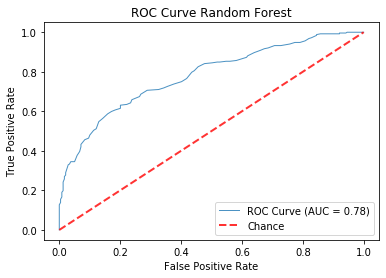

In [146]:
'''
    ROC CURVE
'''

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()